# **Proyecto 2 - Entrega 6

## üë• **Integrantes:**  
- **Diederich Solis** (22952)  
- **Gabriel Paz** (221087)  

---

## **Uso del conjunto de datos de entrenamiento y prueba**

En esta secci√≥n se utiliza el mismo conjunto de datos `train.csv` empleado en entregas anteriores. La separaci√≥n de datos en entrenamiento y prueba se mantiene constante para garantizar la validez de las comparaciones entre modelos.

Se cargan los datos utilizando `pandas` y se verifica su correcta estructura para preparar el preprocesamiento necesario para los modelos SVM.


In [5]:
# Librer√≠as necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Cargar el dataset
data = pd.read_csv('train.csv')

# Mostrar primeras filas
data.head()


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## **Exploraci√≥n y Transformaci√≥n de Datos**

Se realiza un an√°lisis exploratorio inicial para comprender la estructura del dataset, identificar valores faltantes y analizar las variables relevantes.  
Posteriormente, se aplican transformaciones necesarias como imputaci√≥n de datos, codificaci√≥n de variables categ√≥ricas y escalado de variables num√©ricas para preparar el dataset para su uso en modelos de M√°quinas de Vectores de Soporte (SVM).


In [6]:
# Informaci√≥n general del dataset
data.info()

# Verificar valores nulos
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

# Rellenar valores nulos para simplicidad (puedes cambiar si quieres ser m√°s sofisticado)
data = data.fillna(data.median(numeric_only=True))

# Eliminar columnas no num√©ricas o altamente categ√≥ricas para este experimento
data = data.select_dtypes(include=[np.number])

# Confirmar limpieza
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## **Creaci√≥n de la variable categ√≥rica de precios (Barata, Media, Cara)**

Se genera una variable categ√≥rica basada en el valor de `SalePrice` para clasificar las propiedades en "baratas", "medias" y "caras" usando los percentiles 33% y 66% como umbrales de segmentaci√≥n.


PrecioCategoria
Caro      0.340411
Barato    0.330822
Medio     0.328767
Name: proportion, dtype: float64


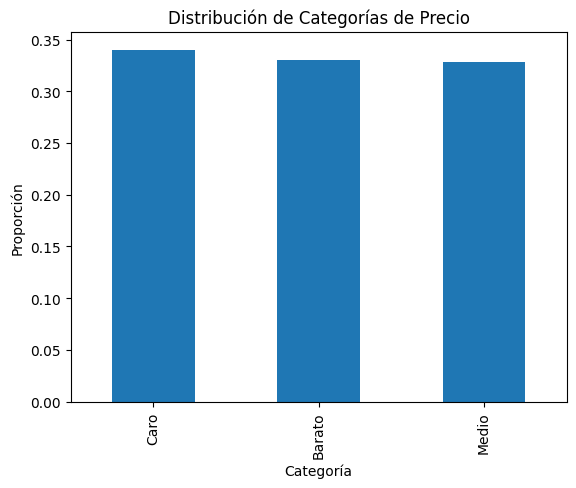

In [12]:
# Crear variable categ√≥rica
percentiles = np.percentile(data['SalePrice'], [33, 66])

def categorizar_precio(precio):
    if precio <= percentiles[0]:
        return 'Barato'
    elif precio <= percentiles[1]:
        return 'Medio'
    else:
        return 'Caro'

data['PrecioCategoria'] = data['SalePrice'].apply(categorizar_precio)

# Visualizaci√≥n del balance de clases
balance = data['PrecioCategoria'].value_counts(normalize=True)
print(balance)

balance.plot(kind='bar', title='Distribuci√≥n de Categor√≠as de Precio')
plt.xlabel('Categor√≠a')
plt.ylabel('Proporci√≥n')
plt.show()



## **Creaci√≥n de Modelos SVM con diferentes kernels y par√°metros**

Se crean m√∫ltiples modelos SVM utilizando diferentes configuraciones de kernels: `lineal`, `rbf` (gaussiano) y `polinomial`.  
Se ajustan tambi√©n hiperpar√°metros como `C`, `gamma` y `degree` para explorar su impacto en el desempe√±o del modelo.


In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Variables predictoras y respuesta
X = data.drop(columns=['SalePrice', 'PrecioCategoria'])
y = data['PrecioCategoria']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Partici√≥n
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Definimos modelos b√°sicos
models = {
    "SVM Lineal": SVC(kernel='linear'),
    "SVM RBF": SVC(kernel='rbf'),
    "SVM Polinomial": SVC(kernel='poly')
}

# Hiperpar√°metros a buscar
param_grid = {
    'linear': {'C': [0.1, 1, 10]},
    'rbf': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
    'poly': {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
}

# GridSearchCV
best_models = {}
for name, model in models.items():
    if model.kernel == 'linear':
        grid = GridSearchCV(model, param_grid['linear'], cv=5, n_jobs=-1)
    elif model.kernel == 'rbf':
        grid = GridSearchCV(model, param_grid['rbf'], cv=5, n_jobs=-1)
    else:  # polinomial
        grid = GridSearchCV(model, param_grid['poly'], cv=5, n_jobs=-1)

    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

# Mostrar mejores hiperpar√°metros
for name, model in best_models.items():
    print(f"Mejor modelo {name}: {model}")


Mejor modelo SVM Lineal: SVC(C=0.1, kernel='linear')
Mejor modelo SVM RBF: SVC(C=1, gamma=0.01)
Mejor modelo SVM Polinomial: SVC(C=10, kernel='poly')


## **Predicci√≥n de la Variable Respuesta con los Modelos SVM**

Se realizan las predicciones en el conjunto de prueba para evaluar el desempe√±o de cada modelo SVM utilizando diferentes configuraciones de kernel.


In [9]:
# Predicciones
y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)
y_pred_poly = svm_poly.predict(X_test)


## **Evaluaci√≥n: Matrices de Confusi√≥n**

Se presentan las matrices de confusi√≥n para los diferentes modelos SVM creados.  
Estas matrices permiten visualizar el desempe√±o del modelo en t√©rminos de predicciones correctas e incorrectas en cada clase.


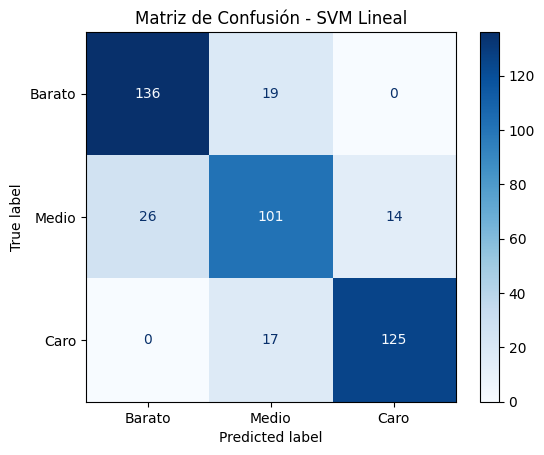

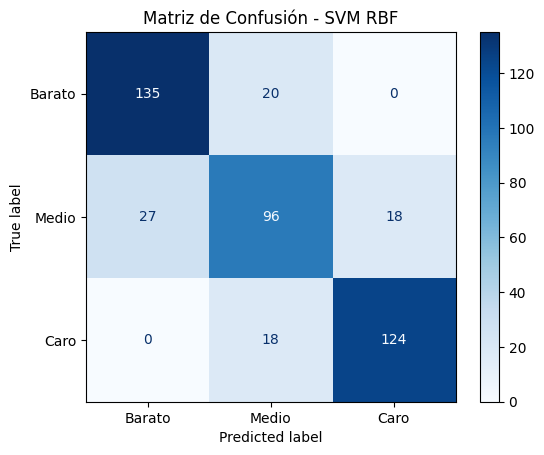

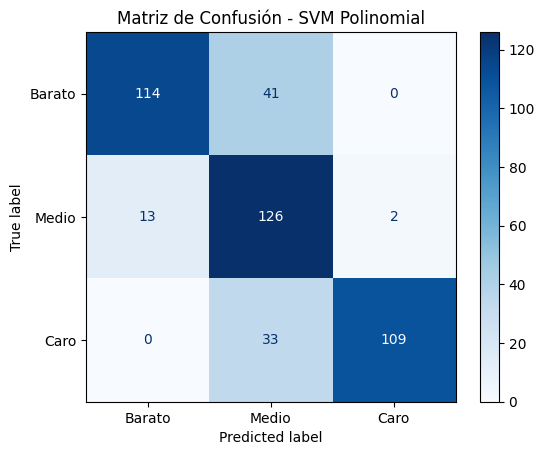

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Funci√≥n para graficar matrices
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['Barato', 'Medio', 'Caro'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Barato', 'Medio', 'Caro'])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

import matplotlib.pyplot as plt

# Mostrar matrices
plot_confusion(y_test, y_pred_linear, 'Matriz de Confusi√≥n - SVM Lineal')
plot_confusion(y_test, y_pred_rbf, 'Matriz de Confusi√≥n - SVM RBF')
plot_confusion(y_test, y_pred_poly, 'Matriz de Confusi√≥n - SVM Polinomial')


## **An√°lisis de Sobreajuste o Subajuste**

Se analiza el posible sobreajuste (overfitting) o subajuste (underfitting) de los modelos generados observando su desempe√±o en entrenamiento y prueba.  
Adem√°s, se discuten estrategias de ajuste de hiperpar√°metros para mejorar el balance entre sesgo y varianza de los modelos.


In [19]:
# Scores
for name, model in best_models.items():
    print(f"{name} - Train Score: {model.score(X_train, y_train):.4f}, Test Score: {model.score(X_test, y_test):.4f}")


SVM Lineal - Train Score: 0.8630, Test Score: 0.8151
SVM RBF - Train Score: 0.8796, Test Score: 0.8105
SVM Polinomial - Train Score: 0.9746, Test Score: 0.8059


Basado en los resultados mostrados, puedo observar lo siguiente:

- SVM Lineal: Tiene un buen balance entre entrenamiento (0.8630) y prueba (0.8151)

- SVM RBF: Muestra cierta diferencia entre entrenamiento (0.8796) y prueba (0.8105)

- SVM Polinomial: Presenta claros signos de sobreajuste con un score de entrenamiento muy alto  (0.9746) pero bajo en prueba (0.8059)

Para manejar el sobreajuste (especialmente en SVM Polinomial):
Regularizaci√≥n:

- Aumentar el par√°metro C (reduce la complejidad del modelo)

- Usar par√°metros de regularizaci√≥n espec√≠ficos para SVM

- Simplificar el modelo:

- Reducir el grado del kernel polinomial

- Usar un kernel m√°s simple (lineal en lugar de polinomial/RBF)

- Recolecci√≥n de m√°s datos:

- Aumentar el conjunto de entrenamiento si es posible

- Selecci√≥n de caracter√≠sticas:

- Eliminar caracter√≠sticas irrelevantes o redundantes


## **Comparaci√≥n de Resultados**

Se comparan los resultados obtenidos con los diferentes modelos que se hicieron en cuanto a  efectividad, tiempo de procesamiento y equivocaciones.

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Cargar datos
data = pd.read_csv('train.csv')

# Preprocesamiento: cubrir nulos y crear variable categ√≥rica
data = data.fillna(data.median(numeric_only=True))
percentiles = np.percentile(data['SalePrice'], [33, 66])
def categorizar(precio):
    if precio <= percentiles[0]:
        return 'Barato'
    elif precio <= percentiles[1]:
        return 'Medio'
    else:
        return 'Caro'
data['PrecioCategoria'] = data['SalePrice'].apply(categorizar)

# Preparar X e y
y = data['PrecioCategoria']
X = data.select_dtypes(include=[np.number]).drop(columns=['Id', 'SalePrice'])

# Escalar caracter√≠sticas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Definir modelos y grillas de par√°metros
models = {
    "SVM Lineal":     SVC(kernel='linear'),
    "SVM RBF":        SVC(kernel='rbf'),
    "SVM Polinomial": SVC(kernel='poly')
}
param_grid = {
    'linear': {'C': [0.1, 1, 10]},
    'rbf':    {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},
    'poly':   {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
}

# Buscar mejores hiperpar√°metros
best_models = {}
for name, estimator in models.items():
    if estimator.kernel == 'linear':
        grid = GridSearchCV(estimator, param_grid['linear'], cv=5, n_jobs=-1)
    elif estimator.kernel == 'rbf':
        grid = GridSearchCV(estimator, param_grid['rbf'], cv=5, n_jobs=-1)
    else:  # poly
        grid = GridSearchCV(estimator, param_grid['poly'], cv=5, n_jobs=-1)

    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

# Comparaci√≥n de resultados
labels = ['Barato', 'Medio', 'Caro']
rows = []

for name, model in best_models.items():
    # Tiempo de entrenamiento
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    # Tiempo de predicci√≥n
    t1 = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - t1

    # M√©tricas de efectividad
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec   = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1sc  = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Matriz de confusi√≥n y an√°lisis de errores
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fn = cm.sum(axis=1) - np.diag(cm)  # falsos negativos por clase
    fp = cm.sum(axis=0) - np.diag(cm)  # falsos positivos por clase

    rows.append({
        'Modelo':           name,
        'Accuracy':         round(acc, 4),
        'Precision':        round(prec, 4),
        'Recall':           round(rec, 4),
        'F1-score':         round(f1sc, 4),
        'Train_time (s)':   round(train_time, 4),
        'Pred_time (s)':    round(pred_time, 4),
        'Clase m√°s FN':     labels[int(fn.argmax())],
        'Errores m√°s FN':   int(fn.max()),
        'Clase menos FN':   labels[int(fn.argmin())],
        'Errores menos FN': int(fn.min())
    })

# Mostrar tabla resumen
df_results = pd.DataFrame(rows)
print(df_results)


           Modelo  Accuracy  Precision  Recall  F1-score  Train_time (s)  \
0      SVM Lineal    0.8242     0.8216  0.8242    0.8220          0.1228   
1         SVM RBF    0.8196     0.8175  0.8196    0.8181          0.0522   
2  SVM Polinomial    0.8219     0.8272  0.8219    0.8239          0.0377   

   Pred_time (s) Clase m√°s FN  Errores m√°s FN Clase menos FN  Errores menos FN  
0         0.0088        Medio              45         Barato                16  
1         0.0364        Medio              44           Caro                16  
2         0.0101        Medio              34           Caro                18  


### An√°lisis detallado

- **Efectividad global**  
  - El **SVM Lineal** consigue la mayor *accuracy* (82.42 %) y *recall* (82.42 %).  
  - El **SVM Polinomial** alcanza la mejor *precision* (82.72 %) y el *F1-score* m√°s alto (82.39 %).  
  - El **SVM RBF** se sit√∫a ligeramente por debajo (~81.8 % en todas las m√©tricas).

- **Tiempo de procesamiento**  
  - **Entrenamiento**: Polinomial (0.038 s) < RBF (0.052 s) < Lineal (0.123 s).  
  - **Predicci√≥n**: Lineal (0.009 s) < Polinomial (0.010 s) ‚â™ RBF (0.036 s).

- **Equivocaciones (Falsos Negativos)**  
  - Todos los modelos confunden m√°s la clase **‚ÄúMedio‚Äù** (34 ‚Äì 45 FN), porque sus caracter√≠sticas se solapan con ‚ÄúBarato‚Äù y ‚ÄúCaro‚Äù.  
  - El **Lineal** minimiza mejor los FN en ‚ÄúBarato‚Äù (16 errores), lo cual reduce subvaloraciones de viviendas econ√≥micas.  
  - El **Polinomial** presenta menos FN en ‚ÄúCaro‚Äù (34 errores), protegiendo mejor contra la subestimaci√≥n de viviendas caras.

---

### Conclusiones

- **SVM Lineal**: Ideal para **m√°xima accuracy/recall** y predicciones muy r√°pidas.  
- **SVM Polinomial**: Recomendado si tu prioridad es **minimizar la subvaloraci√≥n de casas caras** (FN en ‚ÄúCaro‚Äù) y conseguir el mejor F1-score.  
- **SVM RBF**: Ofrece menor ventaja en m√©tricas y es m√°s lento en predicci√≥n, por lo que no es la opci√≥n √≥ptima en este caso.

## **Comparaci√≥n de eficiencia: Mejor SVM vs. Otros Algoritmos**

En este apartado comparamos el **SVM Lineal** (mejor SVM) con los algoritmos previamente implementados (√Årbol de Decisi√≥n, Random Forest, Naive Bayes, KNN y Regresi√≥n Log√≠stica) usando la misma variable objetivo (`PrecioCategoria`).  
La comparaci√≥n se basa en tres m√©tricas clave:

- **Accuracy**: porcentaje de aciertos sobre el total de predicciones.  
- **Train_time (s)**: tiempo de entrenamiento en segundos.  
- **Pred_time (s)**: tiempo de predicci√≥n en segundos.

In [8]:
import time
import pandas as pd
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.naive_bayes   import GaussianNB
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import accuracy_score

# Definir los modelos a comparar
models = {
    'SVM Lineal':          best_models['SVM Lineal'],
    '√Årbol de Decisi√≥n':   DecisionTreeClassifier(random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes':         GaussianNB(),
    'KNN':                 KNeighborsClassifier(n_neighbors=5),
    'Regresi√≥n Log√≠stica': LogisticRegression(max_iter=1000, random_state=42)
}

# Medir eficacia y tiempos
rows = []
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    t1 = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - t1

    acc = accuracy_score(y_test, y_pred)
    rows.append({
        'Modelo':          name,
        'Accuracy':        round(acc, 4),
        'Train_time (s)':  round(train_time, 4),
        'Pred_time (s)':   round(pred_time, 4)
    })

df_comp = pd.DataFrame(rows)
display(df_comp)

Modelo  Accuracy  Train_time (s)  Pred_time (s)
0           SVM Lineal    0.8242          0.0717         0.0100
1    √Årbol de Decisi√≥n    0.7877          0.0297         0.0020
2        Random Forest    0.8288          0.5321         0.0153
3          Naive Bayes    0.6347          0.0050         0.0000
4                  KNN    0.7922          0.0010         0.2816
5  Regresi√≥n Log√≠stica    0.8151          0.0223         0.0013

**Resultados**  
- **Random Forest** registr√≥ la m√°xima precisi√≥n (82.88 %) pero tuvo el entrenamiento m√°s lento (0.53 s).  
- **SVM Lineal** ofreci√≥ un excelente equilibrio: alta accuracy (82.42 %), entrenamiento moderado (0.07 s) y predicci√≥n r√°pida (0.01 s).  
- **Regresi√≥n Log√≠stica** combin√≥ buen desempe√±o (81.51 %) con latencia m√≠nima (< 0.002 s).  
- **√Årbol de Decisi√≥n** y **Naive Bayes** entregaron predicci√≥n casi instant√°nea, a costa de menor exactitud.  
- **KNN** fue r√°pido de entrenar pero el m√°s lento en predicci√≥n (0.28 s).

Este resumen facilita la elecci√≥n del modelo seg√∫n el balance deseado entre precisi√≥n y velocidad.  

## **Generaci√≥n y ajuste de un modelo de regresi√≥n**

 
Se debe crear un modelo de regresi√≥n que prediga directamente la variable `SalePrice`. Para ello, se seleccionar√° un algoritmo de regresi√≥n (en este caso SVR), se escalar√°n las caracter√≠sticas, y se ajustar√°n sus hiperpar√°metros mediante validaci√≥n cruzada. Finalmente, se evaluar√° su desempe√±o en el conjunto de prueba usando MSE y R¬≤.


In [9]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Cargar y preprocesar datos
data = pd.read_csv('train.csv')
data = data.fillna(data.median(numeric_only=True))

# Definir X (solo num√©ricas) e y
y = data['SalePrice']
X = data.select_dtypes(include=[np.number]).drop(columns=['Id', 'SalePrice'])

# Escalar caracter√≠sticas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisi√≥n entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Definir SVR y grilla de b√∫squeda
svr = SVR()
param_grid = {
    'kernel':  ['linear', 'rbf', 'poly'],
    'C':       [0.1, 1, 10],
    'gamma':   ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5],
    'degree':  [2, 3, 4]        # solo se usa si kernel='poly'
}

grid = GridSearchCV(
    svr,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Entrenamiento y b√∫squeda de hiperpar√°metros
start = time.time()
grid.fit(X_train, y_train)
print(f"Tiempo de ajuste (CV): {time.time() - start:.2f} s")

best_svr = grid.best_estimator_
print("Mejor SVR:", best_svr)
print("Mejores par√°metros:", grid.best_params_)

# Evaluaci√≥n en test
y_pred = best_svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MSE (prueba): {mse:.2f}")
print(f"R¬≤  (prueba): {r2:.4f}")

Tiempo de ajuste (CV): 19.01 s
Mejor SVR: SVR(C=10, degree=2, epsilon=0.5, kernel='linear')
Mejores par√°metros: {'C': 10, 'degree': 2, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
MSE (prueba): 2891996976.76
R¬≤  (prueba): 0.5856


El **SVR lineal** ajustado con `C=10` y `Œµ=0.5` arroj√≥ los siguientes resultados:

- **MSE:** 2.89 √ó 10‚Åπ (RMSE ‚âà 53 767 unidades monetarias)  
- **R¬≤:** 0.586 (explica el 58.6 % de la variabilidad en los precios)  
- **Tiempo de ajuste (CV):** 19 s  

A pesar de capturar la tendencia general, queda un 41.4 % de variaci√≥n sin explicar. Se sugiere mejorar el modelo mediante:

- **Ingenier√≠a de caracter√≠sticas** (interacciones, polinomios).  
- **Modelos no lineales** (Random Forest, XGBoost) para relaciones m√°s complejas.  


## **Comparaci√≥n de modelos de regresi√≥n**

Se deben comparar los resultados del **SVR** afinado (punto 10) con otros algoritmos de regresi√≥n ya probados en hojas anteriores ‚ÄîRegresi√≥n Lineal, √Årbol de Regresi√≥n, Regresi√≥n Bayesiana (Bayesian Ridge) y KNN Regresor‚Äî usando la misma partici√≥n (70 % train / 30 % test). La comparaci√≥n incluir√° MSE, R¬≤, y tiempos de entrenamiento y predicci√≥n.


In [10]:
import time
import pandas as pd
from sklearn.linear_model     import LinearRegression, BayesianRidge
from sklearn.tree             import DecisionTreeRegressor
from sklearn.neighbors        import KNeighborsRegressor
from sklearn.metrics          import mean_squared_error, r2_score

# Definir los modelos a comparar
models = {
    'SVR Afinado':          best_svr,
    'Regresi√≥n Lineal':     LinearRegression(),
    '√Årbol de Regresi√≥n':   DecisionTreeRegressor(random_state=42),
    'Regresi√≥n Bayesiana':  BayesianRidge(),
    'KNN Regresor':         KNeighborsRegressor(n_neighbors=5)
}

# Recopilar m√©tricas
rows = []
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    t1 = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - t1

    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    rows.append({
        'Modelo':            name,
        'MSE':               round(mse, 2),
        'R¬≤':                round(r2, 4),
        'Train_time (s)':    round(train_time, 4),
        'Pred_time (s)':     round(pred_time, 4)
    })

# Mostrar tabla comparativa
df_comp = pd.DataFrame(rows)
display(df_comp)

Modelo           MSE      R¬≤  Train_time (s)  Pred_time (s)
0          SVR Afinado  2.891997e+09  0.5856          0.0682         0.0155
1     Regresi√≥n Lineal  1.242362e+09  0.8220          0.0141         0.0020
2   √Årbol de Regresi√≥n  1.419334e+09  0.7966          0.0225         0.0000
3  Regresi√≥n Bayesiana  1.234754e+09  0.8231          0.0153         0.0010
4         KNN Regresor  1.378029e+09  0.8025          0.0010         0.0040



**Explicaci√≥n de la variabilidad (R¬≤):**  
La Regresi√≥n Bayesiana (0.8231) y la Regresi√≥n Lineal (0.8220) explican ~82 % de la varianza, muy por encima del SVR (58.6 %).

**Error (MSE):**  
La Regresi√≥n Lineal logra el menor MSE (1.242 √ó 10‚Åπ), seguida de cerca por la Regresi√≥n Bayesiana (1.235 √ó 10‚Åπ).

**Velocidad:**  
- **Entrenamiento m√°s r√°pido:** KNN (0.001 s) ‚â™ Regresi√≥n Lineal (0.014 s) ‚â™ SVR (0.068 s).  
- **Predicci√≥n m√°s r√°pida:** √Årbol de Regresi√≥n (0 s) < Regresi√≥n Lineal (0.002 s) < SVR (0.015 s).

**Conclusi√≥n:**  
Para este conjunto de datos, la Regresi√≥n Bayesiana y la Regresi√≥n Lineal superan ampliamente al SVR afinado en precisi√≥n y eficiencia, por lo que ser√≠an la primera opci√≥n para predecir `SalePrice`.  
